In [ ]:
import numpy as np 
import pandas as pd
from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import PReLU, LeakyReLU
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from PIL import Image
import os
import random

DATA PREPROCESSING:

In [ ]:
path_test = "C:/Users/student/Downloads/flowers/"

In [ ]:
CATEGORIES = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
IMG_SIZE =200

In [ ]:
training = []
def createTrainingData():
  for category in CATEGORIES:
    path = os.path.join(path_test, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      training.append([new_array, class_num])

createTrainingData()

In [ ]:
random.shuffle(training)

In [ ]:
X =[]
y =[]
for features, label in training:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
X = X.astype('float32')
X /= 255
from keras.utils import np_utils
Y = np_utils.to_categorical(y, 5)
print(Y[100])
print(Y.shape)
print(X.shape)

[0. 0. 0. 1. 0.]
(4317, 5)
(4317, 200, 200, 3)


SPLITTING THE DATASET:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [ ]:
n = int(len(X_test)/2)
x_valid, y_valid = X_test[:n], y_test[:n]
x_test, y_test = X_test[n:], y_test[n:]

In [ ]:
print(X_train.shape)
print(y_train.shape)

(3453, 200, 200, 3)
(3453, 5)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(864, 200, 200, 3)
(432, 5)


In [ ]:
 x_valid.shape, y_valid.shape

((432, 200, 200, 3), (432, 5))

Label:  daisy


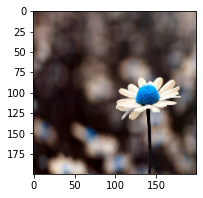

In [ ]:
print('Label: ', CATEGORIES[np.argmax(y_train[7])])
plt.figure(figsize=(3,3))
plt.imshow((X_train[7]))

DEFINE MODEL AND TRAIN:

In [ ]:
def model():
    model = Sequential()

    model.add(Conv2D(128, (3, 3), input_shape=X_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 

    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model()

In [ ]:
checkpointer = ModelCheckpoint(filepath='cnn_model.hdf5', 
                               verbose=2, save_best_only=True)

# To reduce learning rate dynamically
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.2)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 198, 198, 128)     3584      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 198, 198, 128)     0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 99, 99, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 99, 99, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 97, 97, 128)       147584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 97, 97, 128)       0         
                                                      

TRAINING THE MODEL:

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=5, batch_size=32, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer,lr_reduction])

Epoch 1/5

Epoch 1: val_loss improved from inf to 1.16990, saving model to cnn_model.hdf5
108/108 - 219s - loss: 1.2887 - accuracy: 0.4396 - val_loss: 1.1699 - val_accuracy: 0.5602 - lr: 0.0010 - 219s/epoch - 2s/step
Epoch 2/5

Epoch 2: val_loss improved from 1.16990 to 1.03503, saving model to cnn_model.hdf5
108/108 - 219s - loss: 1.0235 - accuracy: 0.5760 - val_loss: 1.0350 - val_accuracy: 0.6181 - lr: 0.0010 - 219s/epoch - 2s/step
Epoch 3/5

Epoch 3: val_loss improved from 1.03503 to 0.90776, saving model to cnn_model.hdf5
108/108 - 222s - loss: 0.8793 - accuracy: 0.6560 - val_loss: 0.9078 - val_accuracy: 0.6551 - lr: 0.0010 - 222s/epoch - 2s/step
Epoch 4/5

Epoch 4: val_loss improved from 0.90776 to 0.90114, saving model to cnn_model.hdf5
108/108 - 218s - loss: 0.8164 - accuracy: 0.6858 - val_loss: 0.9011 - val_accuracy: 0.6875 - lr: 0.0010 - 218s/epoch - 2s/step
Epoch 5/5

Epoch 5: val_loss improved from 0.90114 to 0.86365, saving model to cnn_model.hdf5
108/108 - 222s - loss: 0.8

In [ ]:
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)

dg_history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=64),
                                 steps_per_epoch = len(X_train)//64, epochs=7, verbose=2, 
                                 validation_data=(x_valid, y_valid),
                                 callbacks=[checkpointer,lr_reduction])

In [ ]:
model.load_weights('cnn_model.hdf5')

MODEL EVALUATION:

In [ ]:
score = model.evaluate(x_test, y_test)
score

14/14 [==============================] - 6s 408ms/step - loss: 0.7372 - accuracy: 0.7477


[0.7371581792831421, 0.7476851940155029]

In [ ]:
score = model.evaluate(X_train, y_train)
score

108/108 [==============================] - 47s 435ms/step - loss: 0.7133 - accuracy: 0.7631


[0.7132519483566284, 0.7631045579910278]

In [ ]:
score = model.evaluate(x_valid, y_valid)
score

14/14 [==============================] - 6s 415ms/step - loss: 0.8233 - accuracy: 0.6829


[0.8233286738395691, 0.6828703880310059]

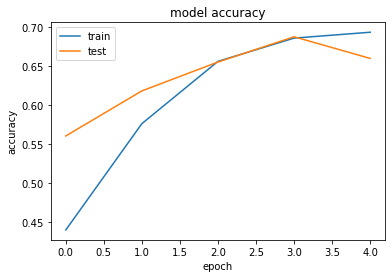

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

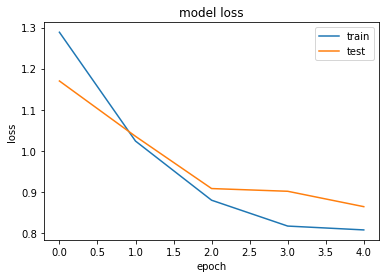

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
model1 = load_model('model.h5')

PREDICTION:

In [ ]:
y_test_predict = model1.predict(x_test)

14/14 [==============================] - 6s 400ms/step


In [ ]:
y_test_predict = np.argmax(y_test_predict,axis=1)

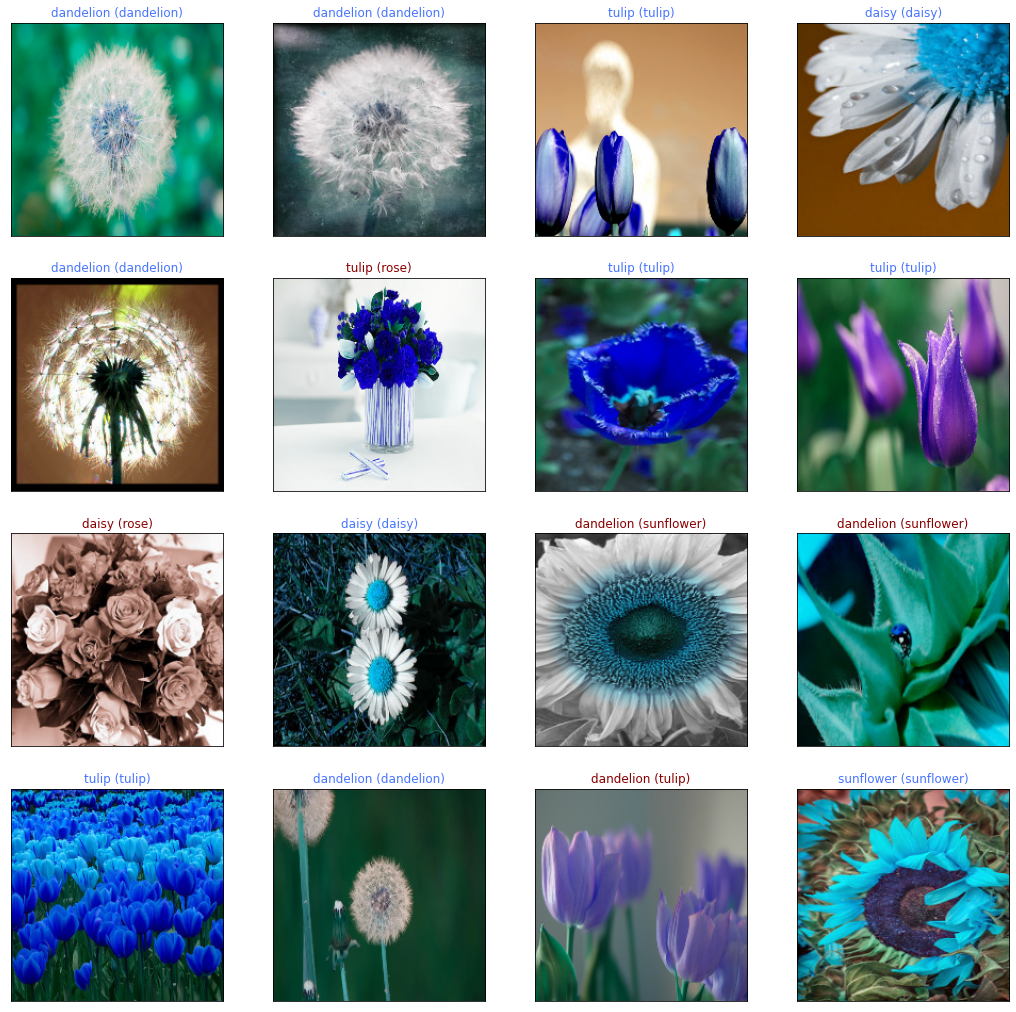

In [ ]:
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(CATEGORIES[pred_idx], CATEGORIES[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))